In [20]:
##Importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate

##Magic line for in notebook
%matplotlib inline

##Turn on matplotlib's interactive mode
plt.ion()

##Directory for figures
direc = "Figures/ZimbabweMagBF/"

# More Zimbabwe Magnetics data

Here we investigate aeromagnetic data from Zimbabwe. Data was given by Prof. Kathy Whaler. The goal is to investigate the effect of different filters applied on the magnetic field strength data. 

In order to apply these filters, the data must be processed first. The following analysis and processing is applied to evaluate the data:
- Examine data range to identify and eliminate outliers
- Interpolate data to get a continuous spectrum

The following filters are then applied to the data:
- First horizontal and vertical derivatives of field strength by Fourier transforming into the frequency domain
- Second vertical derivative calculated in frequency domain
- Upward and downward continuation to highlight and dampen small scale features respectively
- Pie crust filtering to eliminate linear features
- Strike filtering to highlight linear features

Note: Figures will be saved to a subfolder called "ZimbabweMag" of a folder called "Figures". It needs to be in same directory as notebook.

Furthermore note that the data files are expected to be found in a folder called "Data". 

Folders are the best

In [21]:
#### Loading in data file
fn = "Data/BFMag.xyz"

## cols in file:
## 0: Easting (m), 1: Northing (m), Magnetic field (nT)
dat = np.genfromtxt(fn)

## Distributing data into relevant arrays
east = dat[:,0]
north = dat[:,1]
mag = dat[:,2]

## Labels relevant for later plots
eastlabel = "Easting (km)"
northlabel = "Northing (km)"

In [22]:
## Check whether array distribution seems realistic
df = pd.DataFrame(dat).head()
print(df)

          0          1             2
0  702000.0  7797000.0 -3.402823e+38
1  702250.0  7797000.0  3.114000e+04
2  702500.0  7797000.0  3.114000e+04
3  702750.0  7797000.0  3.114000e+04
4  703000.0  7797000.0  3.114000e+04


In [23]:
## Check range of easting and northing of data
erange = np.max(east)-np.min(east)
nrange = np.max(north)-np.min(north)

print("easting range: " + str(np.min(east)) + " to " + str(np.max(east))+ "m. Total range: " 
      + str(erange))
print("northing range: " + str(np.min(north)) + " to " + str(np.max(north)) + "m. Total range: " 
      + str(nrange))

## Print the minimum range. This becomes important when we prepare to Fourier transform the data, which requires the
## the data to be in a sqaure
_range = np.min((erange,nrange))
print(_range)

easting range: 702000.0 to 867000.0m. Total range: 165000.0
northing range: 7668000.0 to 7797000.0m. Total range: 129000.0
129000.0


## Investigating the range of magnetic data to determine outliers

In order to inspect the distribution of magnetic field strength gathered, the most insightful method is to produce a boxplot

minimum magnetic field strength: -3.4028234663852886e+38


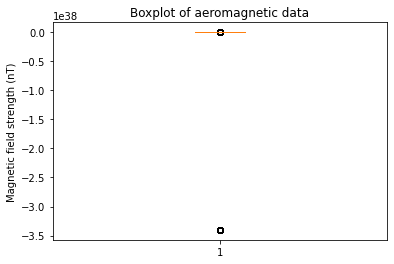

In [24]:
print("minimum magnetic field strength: " + str(np.min(mag)))

boxplot = plt.boxplot(mag)
plt.ylabel("Magnetic field strength (nT)")
plt.title("Boxplot of aeromagnetic data")
plt.show()

The boxplot shows that there is an unreasonable outlier of magnitude $-10^{38}$. In order to determine the impact of this on the data, let us see how many data points are of this value

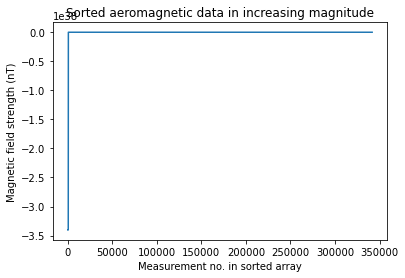

In [25]:
## Let a be a sorted array of magnetic field strengths
a = np.sort(mag)

plt.plot(a)
plt.xlabel("Measurement no. in sorted array")
plt.ylabel("Magnetic field strength (nT)")
plt.title("Sorted aeromagnetic data in increasing magnitude")
plt.show()

We see that there are a small amount of data points of the anomalous value. We will see what the data distribution looks like if we take out measurements of this value. 

C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


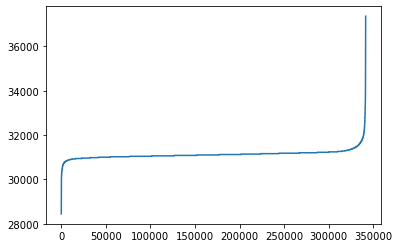

In [26]:
## Masking out the values not equal to -3.5e38
b = [a != np.min(a)]
c = a[b]
plt.plot(c)

Once data points of value $\approx -3.5\times10^{38}$ are taken out, the distribution of magnetic field strength seems more probable. It is safe to assume that points of these values corresponds as NaN's in the measurements, and data points with this value is therefore cut out in the analysis of the Zimbabwe data. 

## Plotting magnetic contours

Here we want to plot a basic contour map of the aeromag data to see the magnetic field distribution over Zimbabwe. The CRS has not been given for this data. This contour plot will therefore help to identify geological features that, in conjunction with a geological map of Zimbabwe, can reveal the geographical setting. This will as well work as a sanity check to the interpolated and filtered maps produced later. 

<Figure size 432x288 with 0 Axes>

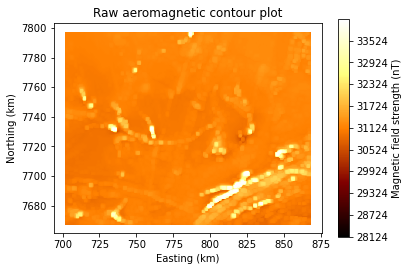

In [27]:
### Choose contour levels to use
var = 3000
levs = np.arange(np.mean(mag[mag>-4e8])-var, np.mean(mag[mag>-4e8])+var, 10)
###### This produces coloured scatter plot of data ######
if(True):
    ## choose which set of colours to use
    cmap = plt.cm.afmhot
    plt.set_cmap(cmap)

    #plt.figure(1)
    #plt.clf()
    
    fig, ax = plt.subplots()
    ax.set_title("Raw aeromagnetic contour plot")
    ax.set_xlabel(eastlabel)
    ax.set_ylabel(northlabel)
    
    nl = len(levs)
    vals = (levs[0:(nl-1)]+levs[1:nl])/2
    cols = cmap(np.linspace(1.0/(nl+1),nl/(nl+1.0),nl-1))

    ## Plot the points
    for i in range(0,len(levs)-1):
        ix = np.where((mag>levs[i]) * (mag <= levs[i+1]))
        ax.plot(east[ix]/1000,north[ix]/1000,"o",markersize=2,color=cols[i])
        
        

        ## This is just so that the map scale is the same in both E-W and N-S
        ax.set_aspect("equal")

    ## Add colour bar.
    sm = plt.cm.ScalarMappable(cmap = cmap,
                               norm = plt.Normalize(vmin=levs[0],
                                                    vmax=levs[nl-1]))
    sm._A = []
    plt.colorbar(sm,boundaries=levs,values=vals, label = "Magnetic field strength (nT)")
    ### Scatter plot finished
    

We see some identifiable structures, as the greenstone belt going down the middle and the some intrusive bodies in the bottom. The fact that the plot is out of focus is not too important, as this issue should be solved in the interpolation. It is more likely that the out-of-focus effect is to do with the plot rather than the data quality. 

In order to Fourier transform the data, we need to cut down the grid into a square with increments that is a multiple of 2. This region is defined by the minimum range of data, called $\_ range$, in the code above.

In [28]:
##### Preparing the data for ffts by creating equally spaced square grid #####
nx = 2**8
ny = 2**8
sqsize = _range ## Size of squares in metres
emin = np.max(east)-sqsize ## Easting in SW corner
emax = np.max(east)
nmin = np.max(north)-sqsize  ## Northing in SW corner
nmax = np.max(north)

## Cut the original data down to the region we care about
## This region is chosen in conjunction with the magnetics data
print("pruning... ")
border = 100000
i1 = north > (nmin - border)
i2 = north < (nmax + border)
i3 = east > (emin - border)
i4 = east < (emax + border)
i5 = np.logical_and(i1, i2)
i6 = np.logical_and(i3, i4)
ix = np.where(np.logical_and(i5, i6))[0]


## For the purposes of deconvolution, we define an origin for 
## x, y coordinates in the middle of the region

xorig = emin + sqsize/2
yorig = nmin + sqsize/2
## Note: With the time given for this project, we have not dealt with euler deconvolution, so the two
## lines above are not important for our code, but is for future years. 

## Creating a mesh-grid with our defined sizes
geast  = np.linspace(emin, emax, nx)
gnorth = np.linspace(nmin, nmax, ny)
ggeast, ggnorth = np.meshgrid(geast, gnorth)
dx = geast[1] - geast[0]
dy = gnorth[1] - gnorth[0]
dk = 1/(nx*dx) ## spatial frequency increments - becomes important in fourier transformations.


east = east[ix]
north = north[ix]
mag = mag[ix]
print("... Done pruning")

## Deal with the dummy values
isbad = mag <-5e10
mag[isbad]=0

## Interpolation the data
### Note: Triangulation doesn't work for areomagnetic data, as data is 
###       collected in lines, so triangulation would be the wrong approach
print("Interpolating...")
interp = interpolate.CloughTocher2DInterpolator((east, north), mag)
gmag = interp(ggeast, ggnorth)
print("... Done interpolation")

pruning... 
... Done pruning
Interpolating...
... Done interpolation


C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


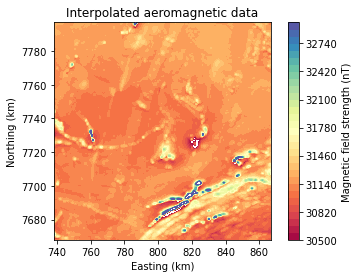

Data points in region: 341737
Area of interest: 16641.0km^2
Data density : 20.536 points per km^2


In [29]:
## Plotting interpolated field
plt.figure(2)
plt.clf()

levs = np.arange(30500, 33000, 80)
plt.contourf(geast/1000, gnorth/1000, gmag, levs, cmap = "Spectral")
plt.axes().set_aspect("equal")
plt.title("Interpolated aeromagnetic data")
plt.xlabel(eastlabel)
plt.ylabel(northlabel)
bar = plt.colorbar(label = "Magnetic field strength (nT)")

plt.savefig(direc + "Interpolated_MagBF")
plt.show()

print("Data points in region: " + str(len(ix)))
print("Area of interest: " + str((sqsize/1000)**2)+"km^2")
print("Data density : " + str(np.round(len(ix)/((sqsize/1000)**2), 3)) + " points per km^2")

Here we see the interpolated magnetic field strength.  The greenstone belt is much more apparent, running down the left side as well as the shear belts in the bottom. There are some interesting highly magnetic intrusions scattered arount the map as well. There are some funny edge effects. This makes sense, as this is the very edge of the map, and these values are likely to be the dummy values we got rid of

## Calculating and plotting 1st and 2nd derivatives 

Calculation of horizontal derivative. The directional derivative wrt to one component in the space domain is equivalent to multiplication of $2\pi k$ in the frequency domain, where k is the wave number

$$ \frac{\partial^n U(x_1, x_2, x_3)}{\partial x_i^n} \leftrightarrow (2\pi i k_i)^n \hat{U}(k_1, k_2, k_3)$$

in which $k_i$ is the wave number fourier transfered from the spatial direction $x_i$ and the hat represents U in the frequency domain. 

Calculation of the vertical derivative. 
The nth vertical derivative can be found by multiplying the fourier transformed data by the radial wavenumber.
$F(\frac{\partial^nU}{\partial z^n}) = F(U)  |k_r|  ^n$ where $|k_r| = \sqrt{k_x^2 + k_y^2}$

The second Vertical gradient can also calculated by assuming Poisson's equation. 
$\nabla ^2 U = 0 \implies \frac{\partial^2U}{\partial z^2} = -\frac{\partial^2U}{\partial x^2} - \frac{\partial^2U}{\partial y^2}$

In [30]:
### Next we need to calculate the three gradients. Before doing this
### we tidy the data up a bit.
print("Calculating gradients...")

## First, subtract the mean value:
gmag = gmag - np.mean(gmag)

## Next we set all nans to 0.
isbad=np.isnan(gmag)
gmag[isbad]=0

## Then, we taper data down to zero at edges to avoid nasty edge effects
winw = 7000 

## This is the width of the taper in grid points
ntaper=int(np.floor(winw/dx))

xfilt = geast*0+1

ix = np.where(geast-geast[0] <= winw)
xfilt[ix] = np.sin(0.5*np.pi*(geast[ix]-geast[0])/winw)**2

ix = np.where(geast[nx-1]-geast <= winw)
xfilt[ix] = np.sin(0.5*np.pi*(geast[nx-1]-geast[ix])/winw)**2
winfilt= np.outer(xfilt,xfilt)
gmag = gmag*winfilt
gmag200 = gmag ## This is marking field strength at measured height. Becomes relevant in
               ## upward continuation

## Calculate X and Y gradients. We use a 1-D FFT for this
kxmag = np.fft.fft(gmag,axis=1)*dx
kymag = np.fft.fft(gmag,axis=0)*dy
kx = np.concatenate((np.linspace(0, (nx//2)*dk, 1 + nx//2),
                   np.linspace(dk*(1-nx//2), -dk, -1 + (nx//2))))
ky = np.concatenate((np.linspace(0, (ny//2)*dk, 1 + ny//2),
                   np.linspace(dk*(1-ny//2), -dk, -1 + (ny//2))))

### Multiply by 2 pi i k to get FT of gradient
kxg,kyg = np.meshgrid(kx,ky)
kdxmag = kxmag*kxg*(0+1j)*2*np.pi
kdymag = kymag*kyg*(0+1j)*2*np.pi


###Multiply by 2 pi i k to get 2nd derivatives
kdx2mag = kdxmag*kxg*(0+1j)*2*np.pi
kdy2mag = kdymag*kyg*(0+1j)*2*np.pi

## Force value at Nyquist freq to zero
kdxmag[:,nx//2]=0
kdymag[ny//2,:]=0
kdx2mag[:,nx//2]=0
kdy2mag[ny//2,:]=0

## Inverse transform to get gradient. 
gdxmag = np.fft.ifft(kdxmag,axis=1)*nx*dk
gdymag = np.fft.ifft(kdymag,axis=0)*ny*dk
gdx2mag = np.fft.ifft(kdx2mag,axis=1)*nx*dk
gdy2mag = np.fft.ifft(kdy2mag,axis=0)*ny*dk

## Calculate the Z gradient.
kzg = np.sqrt(kxg*kxg + kyg*kyg)
kzmag = np.fft.fft2(gmag)*dx*dy
kdzmag = kzmag*2*np.pi*kzg
gdzmag = np.fft.ifft2(kdzmag)*dk*dk*nx*ny

## Calculate the 2nd Z derivative

#### Calculate the 2nd Z gradient using 2D FFT
kdz2mag = kzmag*2*np.pi*kzg**2
gdz2mag = np.fft.ifft2(kdz2mag)*dk*dk*nx*ny
#### Calculate the 2nd Z gradient using Poisson's equation
gdz2magpoisson = -(gdx2mag + gdy2mag)

## Force gradient to be real. Numerical roundoff leads to tiny
## imaginary parts if we don't do this.
gdxmag=gdxmag.real
gdymag=gdymag.real
gdzmag=gdzmag.real
gdx2mag=gdx2mag.real
gdy2mag=gdy2mag.real
gdz2mag=gdz2mag.real
gdz2magpoisson=gdz2magpoisson.real


print("... gradients calculated")

Calculating gradients...
... gradients calculated


C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

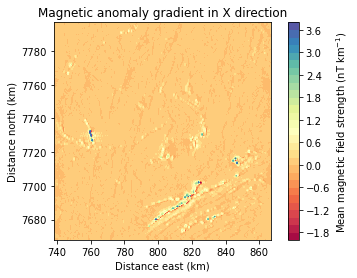

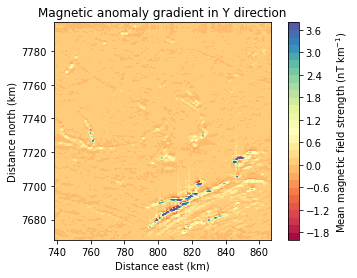

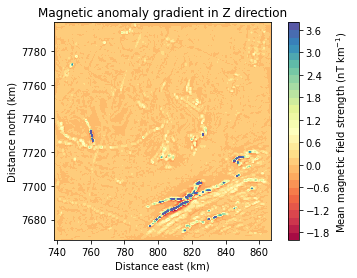

In [31]:
#### Plot deriavatives

##Titles and stuff
xlabel = "Distance east (km)"
ylabel = "Distance north (km)"
barlabel = "Mean magnetic field strength (nT km$^{-1}$)"
title = "Magnetic anomaly gradient in "
levs = np.arange(-2,4, 0.2)
##X derivative
plt.figure(3)
plt.clf()
plt.contourf(geast/1000, gnorth/1000, gdxmag, levs, cmap = "Spectral")

plt.title(title + "X direction")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axes().set_aspect("equal")
bar = plt.colorbar(label=barlabel)

##Y derivative
plt.figure(4)
plt.clf()
plt.contourf(geast/1000, gnorth/1000, gdymag, levs, cmap = "Spectral")

plt.title(title + "Y direction")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axes().set_aspect("equal")
bar = plt.colorbar(label=barlabel)

##Z derivative
plt.figure(5)
plt.clf()
plt.contourf(geast/1000, gnorth/1000, gdzmag, levs, cmap = "Spectral")

plt.title(title + "Z direction")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axes().set_aspect("equal")
bar = plt.colorbar(label=barlabel)

C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lewis\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

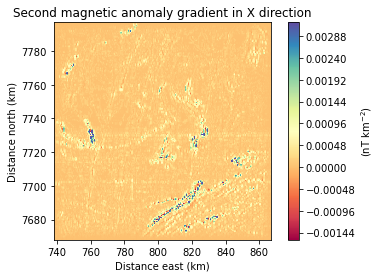

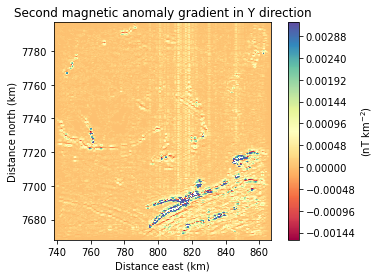

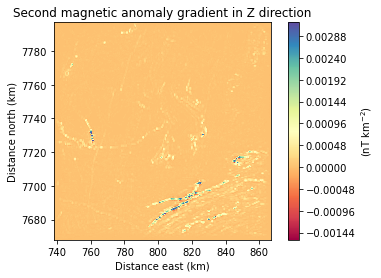

In [32]:
#### Plotting second derivatives

##Titles and stuff
xlabel = "Distance east (km)"
ylabel = "Distance north (km)"
barlabel = "(nT km$^{-2}$)"
title = "Second magnetic anomaly gradient in "
levs = np.arange(-0.0016,0.0032, 0.00002)
##X derivative
plt.figure(3)
plt.clf()
plt.contourf(geast/1000, gnorth/1000, gdx2mag, levs, cmap = "Spectral")

plt.title(title + "X direction")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axes().set_aspect("equal")
bar = plt.colorbar(label=barlabel)

##Y derivative
plt.figure(4)
plt.clf()
plt.contourf(geast/1000, gnorth/1000, gdy2mag, levs, cmap = "Spectral")

plt.title(title + "Y direction")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axes().set_aspect("equal")
bar = plt.colorbar(label=barlabel)

##Z derivative
plt.figure(5)
plt.clf()
plt.contourf(geast/1000, gnorth/1000, gdz2mag, levs, cmap = "Spectral")

plt.title(title + "Z direction")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.axes().set_aspect("equal")
bar = plt.colorbar(label=barlabel)

## Upward Continuation

Upward continuation is done by convolving the potential field with $e^{-H k}$, in which $H$ is the height we wish to synthetically measure the potential at, and $k^2 = k_1^2 + k_2^2$. From the convolution theorem, convolution in the spatial domain is multiplication in the (spatial)-frequency domain. 

NOTE: Since aeromagnetic data is gathered in air, it's possible to downward continue data to ground level by upward continuing by $-H$. 

In [33]:
## Define funtion for upward continuation
def UpwardContinuation(H, gmagLVL):
    '''Function which takes magnetic field strength measured at a given level and returns upward continued data at input height H.
    This is done using a 2D Fourier transform and multiplying by height factor e^(-Hk)'''
    from scipy.fftpack import fft2, ifft2, fftfreq
    
    #### Moving the magnetic measurements by a height H ####
    
    ## Take 2D FFT of magnetic data
    kmagH = fft2(gmagLVL)         #2D FFT
    n_value = fftfreq(nx, (1/nx)) #Gives frequencies of 2D FFT
    
    ## Initialise arrays to hold wave no. coordinates of each cell
    kx_array = np.zeros((nx,nx), dtype = float)
    ky_array = np.zeros((ny,ny), dtype = float)
    k_array  = np.zeros((nx,ny), dtype = float)
    
    ## Defining length of spatial domain. This assumes spatial domain unit is metres
    x_len = sqsize
    y_len = sqsize
    
    ## Loops to calculate wave no.s
    for row in range(nx):
        for col in range(nx):
            kx_array[row][col] = (2.0 * np.pi * n_value[col])/x_len
            ky_array[row][col] = (2.0 * np.pi * n_value[row])/y_len
            
            #Pythagoras to find total vertical wave no.
            k_array[row][col] = np.sqrt(kx_array[row][col]**2 + ky_array[row][col]**2)
    ## Now kx, ky and k hold the wave domain coordinates of corresponding gmag in k-domain
    
    ## Upward continuation
    kmagH = kmagH * np.exp(-H*k_array)
    
    ## Forcing Nyquist frequency to zero
    kmagH[:,nx//2] = 0
    kmagH[ny//2,:] = 0
    
    ## Inverse FFT back to space domain and force data to be real
    gmagH = ifft2(kmagH)
    gmagH = gmagH.real
    
    return(gmagH)
    
    


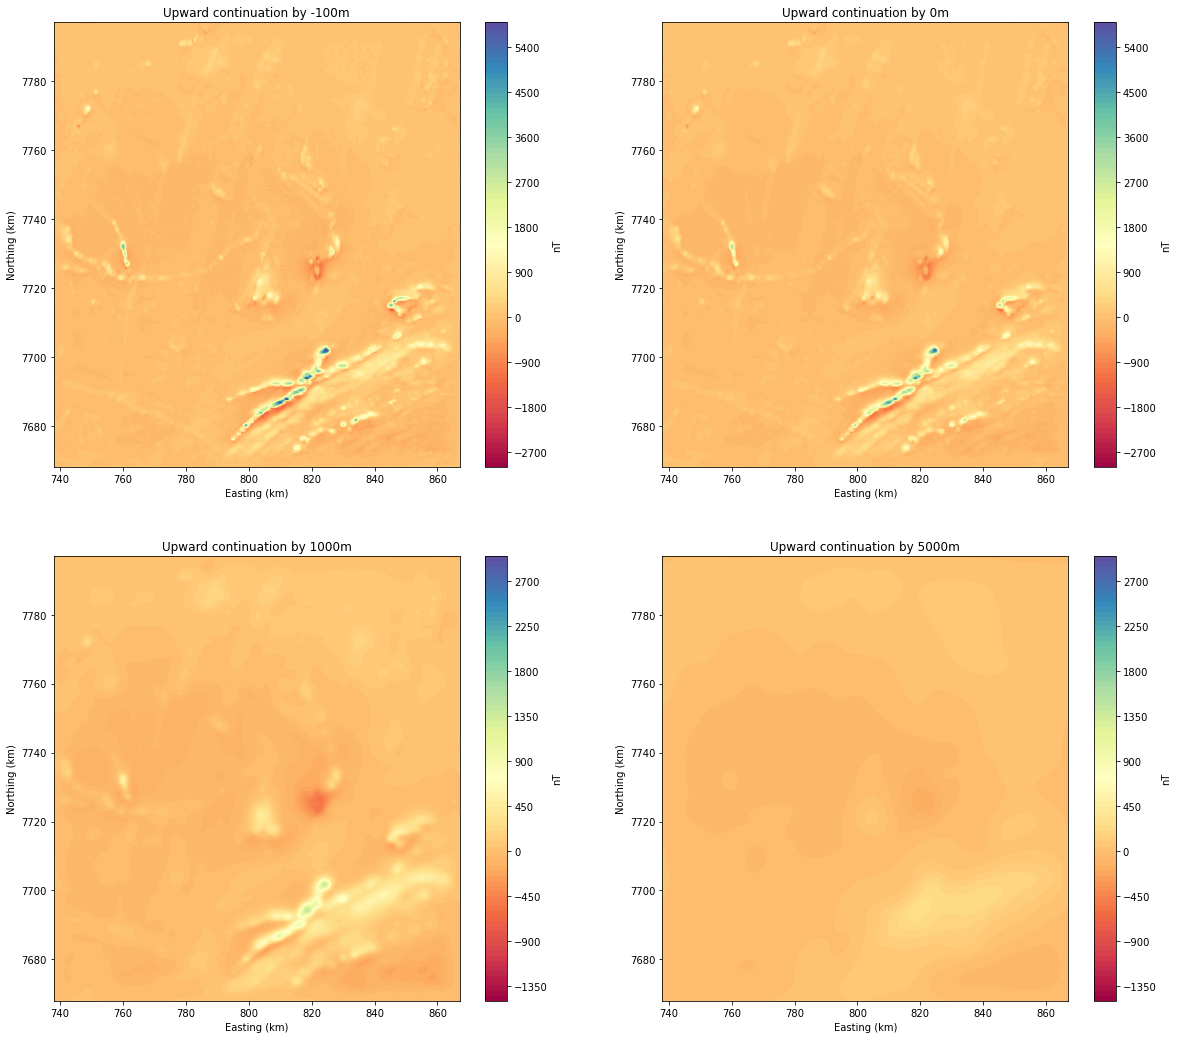

In [34]:
## Upward and downward continuate data
fig, axs = plt.subplots(2,2, figsize = [20, 18])#, sharex = True, sharey = True)
Hs = np.array([[-100, 0], [1000, 5000]])

levs = np.arange(-3000, 6000, 100)
for i in range(2):
    for j in range(2):
        im = axs[i,j].contourf(geast/1000, gnorth/1000, UpwardContinuation(Hs[i,j], gmag200), levs/(i+1), cmap = "Spectral")
        bar = plt.colorbar(im, ax=axs[i,j], label = "nT")
        axs[i,j].set(xlabel = eastlabel, ylabel = northlabel, title = "Upward continuation by " + str(Hs[i,j]) + "m")
        

## Strike filtering

Strike filtering is done by convolving the potential field by $e^{-Hk|{\cos(\theta) + \phi}|}$ in the spatial domain, where $\theta$ is the angle of which we wish to enhance and $\phi = \tan^-1(\frac{k_1}{k_2})$. $H$ is the height we need to apply the strike filter at and $k^2 = k_1^2 + k_2^2$ as before. Again, by the convolution theorem, we are gonna multiply this in the spatial frequency domain and then inverse transfer to achieve this convolution.

In [35]:
## Define function for pie crust filtering
def StrikeFilter(theta, H, gmagLVL):
    '''Function that upward continues by height H and then enhances features that strike at an angle
    theta (given in degrees). This is done using a 2D Fourier transform and multiplying by factor e^(-Hk|cos(theta)+phi), 
    in which phi is arctan(k_x, k_y)'''
    import math
    from scipy.fftpack import fft2, ifft2, fftfreq
    
    ## Converting theta into radians
    thet = np.radians(theta)
    
    ## Take 2D FFT of magnetic data
    kmagS = fft2(gmagLVL)         #2D FFT
    n_value = fftfreq(nx, (1/nx)) #Gives frequencies of 2D FFT
    
    ## Initialise arrays to hold wave no. coordinates of each cell
    kx_array = np.zeros((nx,nx), dtype = float)
    ky_array = np.zeros((ny,ny), dtype = float)
    k_array  = np.zeros((nx,ny), dtype = float)
    phi_array= np.zeros((nx,ny), dtype = float)
    
    ## Defining length of spatial domain. This assumes spatial domain unit is metres
    x_len = sqsize
    y_len = sqsize
    
    ## Loops to calculate wave no.s
    for row in range(nx):
        for col in range(nx):
            kx_array[row][col] = (2.0 * np.pi * n_value[col])/x_len
            ky_array[row][col] = (2.0 * np.pi * n_value[row])/y_len
            
            ## Pythagoras to find total vertical wave no.
            k_array[row][col] = np.sqrt(kx_array[0][row]**2 + ky_array[0][col]**2)
            
            ## Arctan of kx/ky to find phi
            
            phi_array[row][col] = math.atan2(kx_array[row][col],ky_array[row][col])
            
    ## Now kx, ky, k and phi hold the wave domain coordinates of corresponding gmag in k-domain
    
    ## Apply strike filter
    kmagS = kmagS * np.exp(-H*k_array*abs(np.cos(thet)+phi_array))
    
    ## Forcing Nyquist frequency to zero
    kmagS[:,nx//2] = 0
    kmagS[ny//2,:] = 0
    
    ## Inverse FFT back to space domain and force data to be real
    gmagS = ifft2(kmagS)
    gmagS = gmagS.real
    
    return gmagS
    
    
    

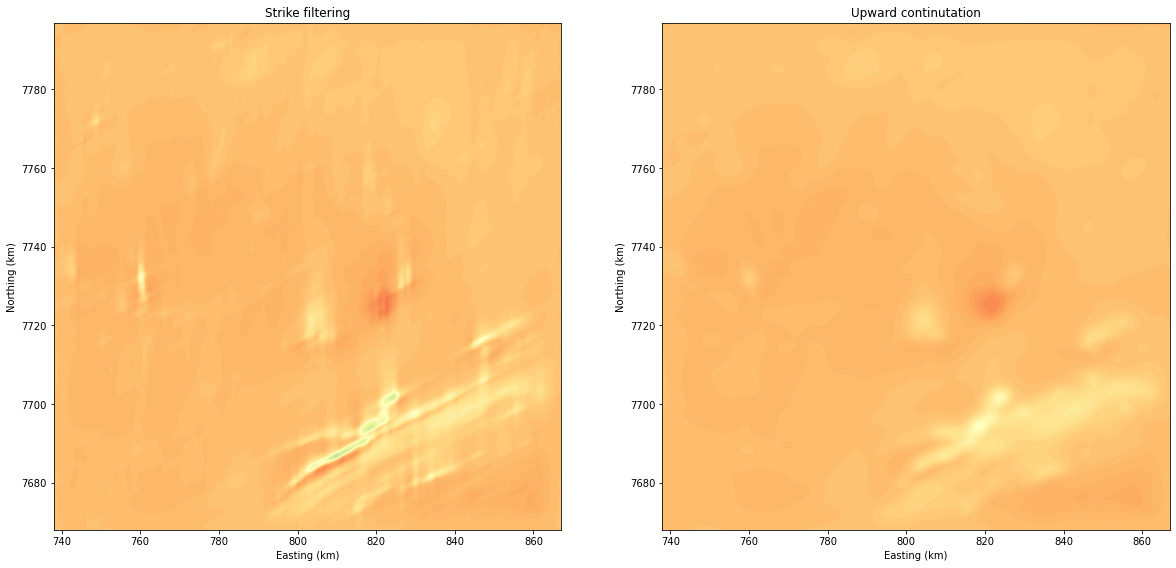

In [36]:
## Plot pie crust filtered data with
angle = 60 #degrees
height= 2000 #metres
levs = np.arange(-3000, 6000, 100)

fig, ax = plt.subplots(1,2, figsize = [20, 10])
ax[0].contourf(geast/1000, gnorth/1000, StrikeFilter(angle, height, gmag200), levs/2, cmap ="Spectral")
ax[0].set_title("Strike filtering")
ax[1].contourf(geast/1000, gnorth/1000, UpwardContinuation(height, gmag200), levs/2, cmap ="Spectral")
ax[1].set_title("Upward continutation")
#ax[1].grid()
for i in range(2):
    ax[i].set(xlabel = eastlabel, ylabel = northlabel, aspect = "equal")


## Pie crust filtering

In [37]:
def PieCrustFilter(angle, dangle, gmagLVL):
    '''Function that multiplies interpolated potential data by 0 when striking at given angle
    +-dangle and everything else by 1. This is done 2D Fourier Transforming potential data and multiplying
    pie crust filter in frequency domain'''
    import math
    from scipy.fftpack import fft2 ,ifft2, fftfreq
    
    ## Converting angles into radians
    phi0 = np.radians(angle+90)
    dphi = np.radians(dangle)
    
    ## Take 2D Fourier transform of potential data
    kmagP = fft2(gmagLVL)          ## 2D FFT
    n_value = fftfreq(nx, (1/nx))  ## Gives frequencies of 2D FFT
    
    ## Initialise arrays to hold wave no. coordinates of each cell
    kx_array = np.zeros((nx,nx), dtype = float)
    ky_array = np.zeros((ny,ny), dtype = float)
    k_array  = np.zeros((nx,ny), dtype = float)
    phi_array= np.zeros((nx,ny), dtype = float)
    
    ## Defining length of spatial domain. This assumes spatial domain unit is metres
    x_len = sqsize
    y_len = sqsize
    
    ## Loops to calculate wave no.s
    for row in range(nx):
        for col in range(nx):
            kx_array[row][col] = (2.0 * np.pi * n_value[col])/x_len
            ky_array[row][col] = (2.0 * np.pi * n_value[row])/y_len
            
            ## Arctan of kx/ky to find phi
            
            phi_array[row][col] = math.atan2(kx_array[row][col],ky_array[row][col])
            
    ## Now kx, ky, k and phi hold the wave domain coordinates of corresponding gmag in k-domain
    
    ## Define wedge function W(phi) in which Pie Crust filter acts. Below is the W function
    def W(phi_array, phi0, dphi):
        with np.nditer(phi_array, op_flags=['readwrite']) as it:
            for phi in it:
                if (phi0 - dphi) < phi:
                    if phi < (phi0 + dphi):
                        phi[...] = 0
                    else:
                        phi[...] = 1
                elif (phi0 - dphi) < (phi + np.pi):
                    if (phi + np.pi) < (phi0 + dphi):
                        phi[...] = 0
                    else:
                        phi[...] = 1
                else:
                        phi[...] = 1
        return phi_array
    
    ## Apply Pie Crust filter
    pie_crust = W(phi_array, phi0, dphi)
    kmagP = np.multiply(kmagP,pie_crust)
    

    ## Forcing Nyquist frequency to zero
    kmagP[:,nx//2] = 0
    kmagP[ny//2,:] = 0
    
    ## Inverse FFT back to space domain and force data to be real
    gmagP = ifft2(kmagP)
    gmagP = gmagP.real
    
    return(gmagP)
    
    

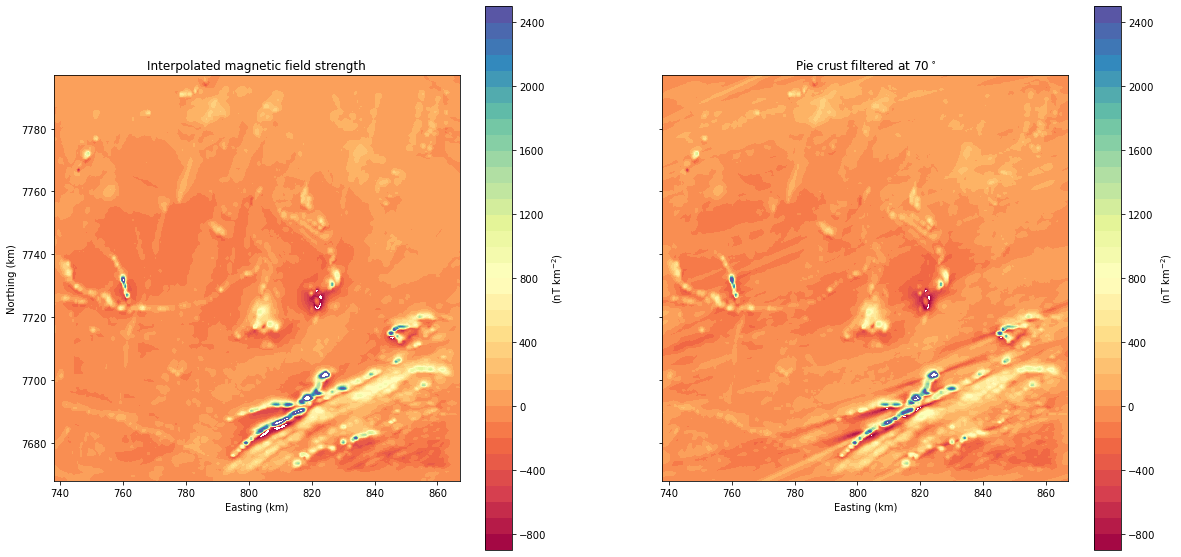

In [38]:
## Apply and compare Pie crust filtered data to raw interpolated data
angle = 70 #degrees
dangle= 5 #degrees

levs = np.arange(-900, 2600, 100)

fig, axs = plt.subplots(1,2, sharey = True, figsize = [20, 10])

im0 = axs[0].contourf(geast/1000, gnorth/1000, gmag200, levs, cmap ="Spectral")
axs[0].set(xlabel = eastlabel, ylabel = northlabel, title = "Interpolated magnetic field strength", aspect ="equal")
im1 = axs[1].contourf(geast/1000, gnorth/1000, PieCrustFilter(angle, dangle, gmag200), levs, cmap = "Spectral")
axs[1].set(xlabel = eastlabel, title = "Pie crust filtered at " + str(angle)+"$^\circ$", aspect = "equal")
for i in range(2):
    bar = plt.colorbar(im1, ax =axs[i], label = barlabel)
